In [10]:
import pandas as pd
import os
import numpy
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import networkx as nx

os.chdir(r'D:\wangx\Documents\GitHub\project\subway accessibility')
pd.set_option ('display.max_columns', None)

### Data Preprocessing

In [3]:
timing = pd.read_excel('bj_subway_timing_24.xlsx')

In [5]:
timing['starttime'] = pd.to_datetime(timing['starttime'], format='%H:%M:%S') # for '--': set to be missing for manual adjustment
timing['starttime'] = timing.apply(
    lambda row: row['starttime'] + pd.Timedelta(days=1) if pd.notna(row['starttime']) and row['starttime'].hour == 0 else row['starttime'], 
    axis=1
) # change the 0:00+ to be the next day
timing = timing.sort_values(by=['line','starttime'])
timing['station2'] = timing.groupby('line')['station1'].shift(-1) # match the later station
timing['arrivetime'] = timing.groupby('line')['starttime'].shift(-1) # match the later time
timing = timing.dropna(subset='station2') # drop missing the last station - no match

In [6]:
timing

,station1,starttime,line,station2,arrivetime
0,古城,1900-01-01 22:51:00,1,八角游乐园,1900-01-01 22:54:00
1,八角游乐园,1900-01-01 22:54:00,1,八宝山,1900-01-01 22:57:00
2,八宝山,1900-01-01 22:57:00,1,玉泉路,1900-01-01 22:59:00
3,玉泉路,1900-01-01 22:59:00,1,五棵松,1900-01-01 23:02:00
4,五棵松,1900-01-01 23:02:00,1,万寿路,1900-01-01 23:05:00
...,...,...,...,...,...
410,荣昌东街,1900-01-01 06:20:00,yz,同济南路,1900-01-01 06:23:00
411,同济南路,1900-01-01 06:23:00,yz,经海路,1900-01-01 06:26:00
412,经海路,1900-01-01 06:26:00,yz,次渠南,1900-01-01 06:29:00
413,次渠南,1900-01-01 06:29:00,yz,次渠,1900-01-01 06:31:00


In [7]:
timing['time_diff'] = timing['arrivetime'] - timing['starttime']
timing['time'] = timing['time_diff'].dt.total_seconds() / 60

In [9]:
timing['time'].describe()

count    432.000000
mean       2.759259
std        1.408429
min        1.000000
25%        2.000000
50%        3.000000
75%        3.000000
max       19.000000
Name: time, dtype: float64

### Have Fun with the Data
- Connected?
- Shortest path?
- Shortest time?

In [11]:
# Visualizatio function
def draw(G, pos, measures, measure_name):
    plt.figure(figsize=(20,20))
    nodes = nx.draw_networkx_nodes(G, pos, node_size=250, cmap=plt.cm.plasma, 
                                   node_color=list(measures.values()),
                                   nodelist=measures.keys())
    nodes.set_norm(mcolors.SymLogNorm(linthresh=0.01, linscale=1, base=10))
    # labels = nx.draw_networkx_edge_labels(G, pos)
    edges = nx.draw_networkx_edges(G, pos)

    plt.title(measure_name, fontsize=30)
    plt.colorbar(nodes)
    plt.axis('off')
    plt.show()

In [13]:
# Dictionary sorting function
def dict_sort_by_name(dict_input):
    '''
    Input dictionary, output sorted dictionary
    '''
    return sorted(dict_input.items(), key=lambda x: x[1], reverse=True)

In [14]:
# create graph
G = nx.Graph()
# create the graph from dataset
for idx, row in timing.iterrows():
    G.add_edges_from([(row['station1'],row['station2'])], line=row['line'], time=row['time'])

In [16]:
# check if connected
is_connected = nx.is_connected(G)
print(f"Graph is connected: {is_connected}")

Graph is connected: True


In [18]:
# If not connect, get the number of connected components. If connected:
num_components = nx.number_connected_components(G)
print(f"Number of connected components: {num_components}")
# List the connected components
components = nx.connected_components(G)
for i, component in enumerate(components):
    print(f"Component {i+1}: {component}")

Number of connected components: 1
Component 1: {'灯市口', '旧宫', '什刹海', '大瓦窑', '北京', '郭庄子', '望京南', '朱辛庄', '同济南路', '珠市口', '西苑', '永丰', '学院桥', '清河小营桥', '北海北', '立水桥', '肖村', '北京西', '鼓楼大街', '良乡大学城北', '花庄', '北苑路北', '林萃桥', '石门', '劲松', '车公庄', '杨庄', '金安桥', '十三陵景区', '北新桥', '通州北关', '军事博物馆', '物资学院路', '八角游乐园', '上地', '长阳', '顺义', '草桥', '东大桥', '建国门', '呼家楼', '丰台科技园', '六里桥东', '东管头', '六道口', '玉渊潭东门', '十里堡', '五道口', '科怡路', '西铁营', '玉泉路', '北宫门', '十八里店', '柳芳', '达官营', '天安门西', '国展', '亮马桥', 'T3航', '北辛安', '果园', '回龙观', '东四十条', '屯佃', '万盛西', '善各庄', '成寿寺', '四道桥', '潘家园', '森林公园南门', '苏庄', '和义', '知春里', '花乡东桥', '惠新西街北口', '东四', '次渠北', '魏公村', '环球度假区', '阎村', '木樨地', '园博园', '小红门', '高楼金', '望京', '榆树庄', '草房', '南礼士路', '广渠门内', '枣营', '廖公庄', '刘家窑', '大井', '郝家府', '平乐园', '褡裢坡', '篱笆房', '沙河高教园', '育新', '饶乐府', '二里沟', '八宝山', '万寿寺', '黄渠', '人民大学', '太平桥', '良乡大学城', '南楼梓庄', '百子湾', '模式口', '欢乐谷景区', '木樨园', '梨园', '丰台东大街', '黑庄户', '西北旺', '朝阳门', '广阳城', '土桥', '万寿路', '张自忠路', '双桥', '奥林匹克公园', '俸伯', '义和庄', '望京西', '长春桥', '菜户营', '北太平庄', '丰台南路', '立水桥南', '小园', '霍营', '

In [19]:
print(len(G), len(G.nodes), len(G.edges))

369 369 430


In [20]:
G.edges['古城','八角游乐园']

{'line': 1, 'time': 3.0}

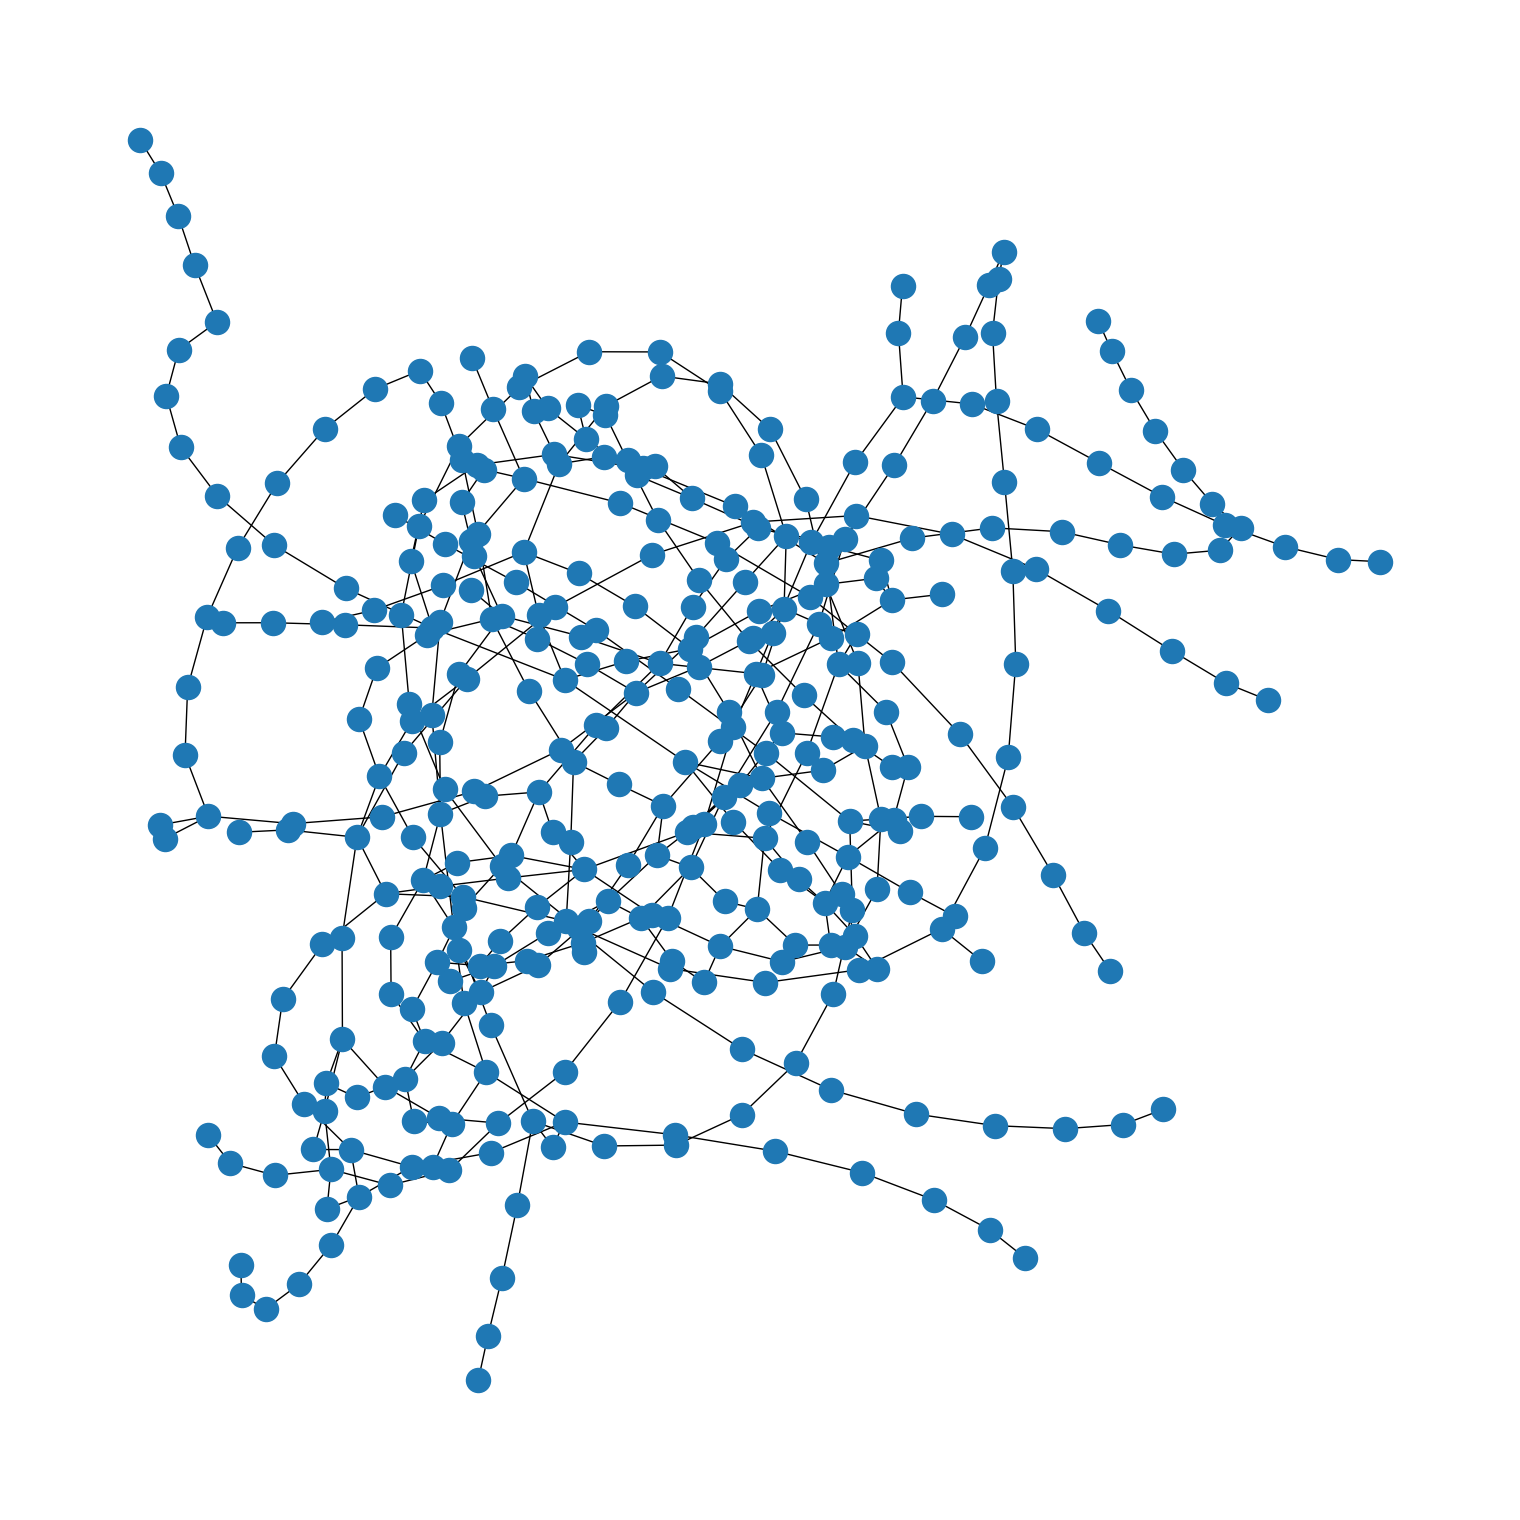

In [23]:
# Visualization
pos = nx.spring_layout(G, seed=123) # default spring layout
plt.figure(figsize=(15,15))
nx.draw(G, pos=pos)

In [24]:
# Shortest path to examine
nx.has_path(G, source='人民大学', target='复兴门')

True

In [25]:
nx.shortest_path(G, source='人民大学',target='复兴门', weight='time')

['人民大学', '魏公村', '国家图书馆', '动物园', '西直门', '车公庄', '阜成门', '复兴门']

In [26]:
nx.shortest_path_length(G, source='人民大学',target='复兴门', weight='time')

16.0

### Centrality Calculation

[('平安里', 6), ('国家图书馆', 5), ('十里河', 5), ('草桥', 5), ('东直门', 5), ('公主坟', 4), ('军事博物馆', 4), ('木樨地', 4), ('复兴门', 4), ('西单', 4), ('王府井', 4), ('东单', 4), ('建国门', 4), ('国贸', 4), ('大望路', 4), ('西苑', 4), ('海淀黄庄', 4), ('西直门', 4), ('宣武门', 4), ('菜市口', 4), ('北京南', 4), ('角门西', 4), ('知春路', 4), ('北土城', 4), ('惠新西街南口', 4), ('芍药居', 4), ('三元桥', 4), ('呼家楼', 4), ('双井', 4), ('宋家庄', 4), ('首经贸', 4), ('丰台', 4), ('西局', 4), ('六里桥', 4), ('慈寿寺', 4), ('金安桥', 4), ('望京西', 4), ('立水桥', 4), ('霍营', 4), ('七里庄', 4), ('景风门', 4), ('永定门外', 4), ('蒲黄榆', 4), ('九龙山', 4), ('金台路', 4), ('望京', 4), ('大屯路东', 4), ('奥林匹克公园', 4), ('六道口', 4), ('丰台南路', 4), ('达官营', 4), ('二里沟', 4), ('次渠', 4), ('积水潭', 4), ('车公庄', 4), ('前门', 4), ('崇文门', 4), ('朝阳门', 4), ('雍和宫', 4), ('磁器口', 4), ('东四', 4), ('白石桥南', 4), ('南锣鼓巷', 4), ('珠市口', 4), ('花庄', 3), ('新宫', 3), ('西土城', 3), ('牡丹园', 3), ('西二旗', 3), ('清河站', 3), ('东管头南', 3), ('鼓楼大街', 3), ('北新桥', 3), ('北京西', 3), ('朱辛庄', 3), ('郭公庄', 3), ('阎村东', 3), ('八角游乐园', 2), ('八宝山', 2), ('玉泉路', 2), ('五棵松', 2), ('万寿路', 2), ('南礼士路', 2

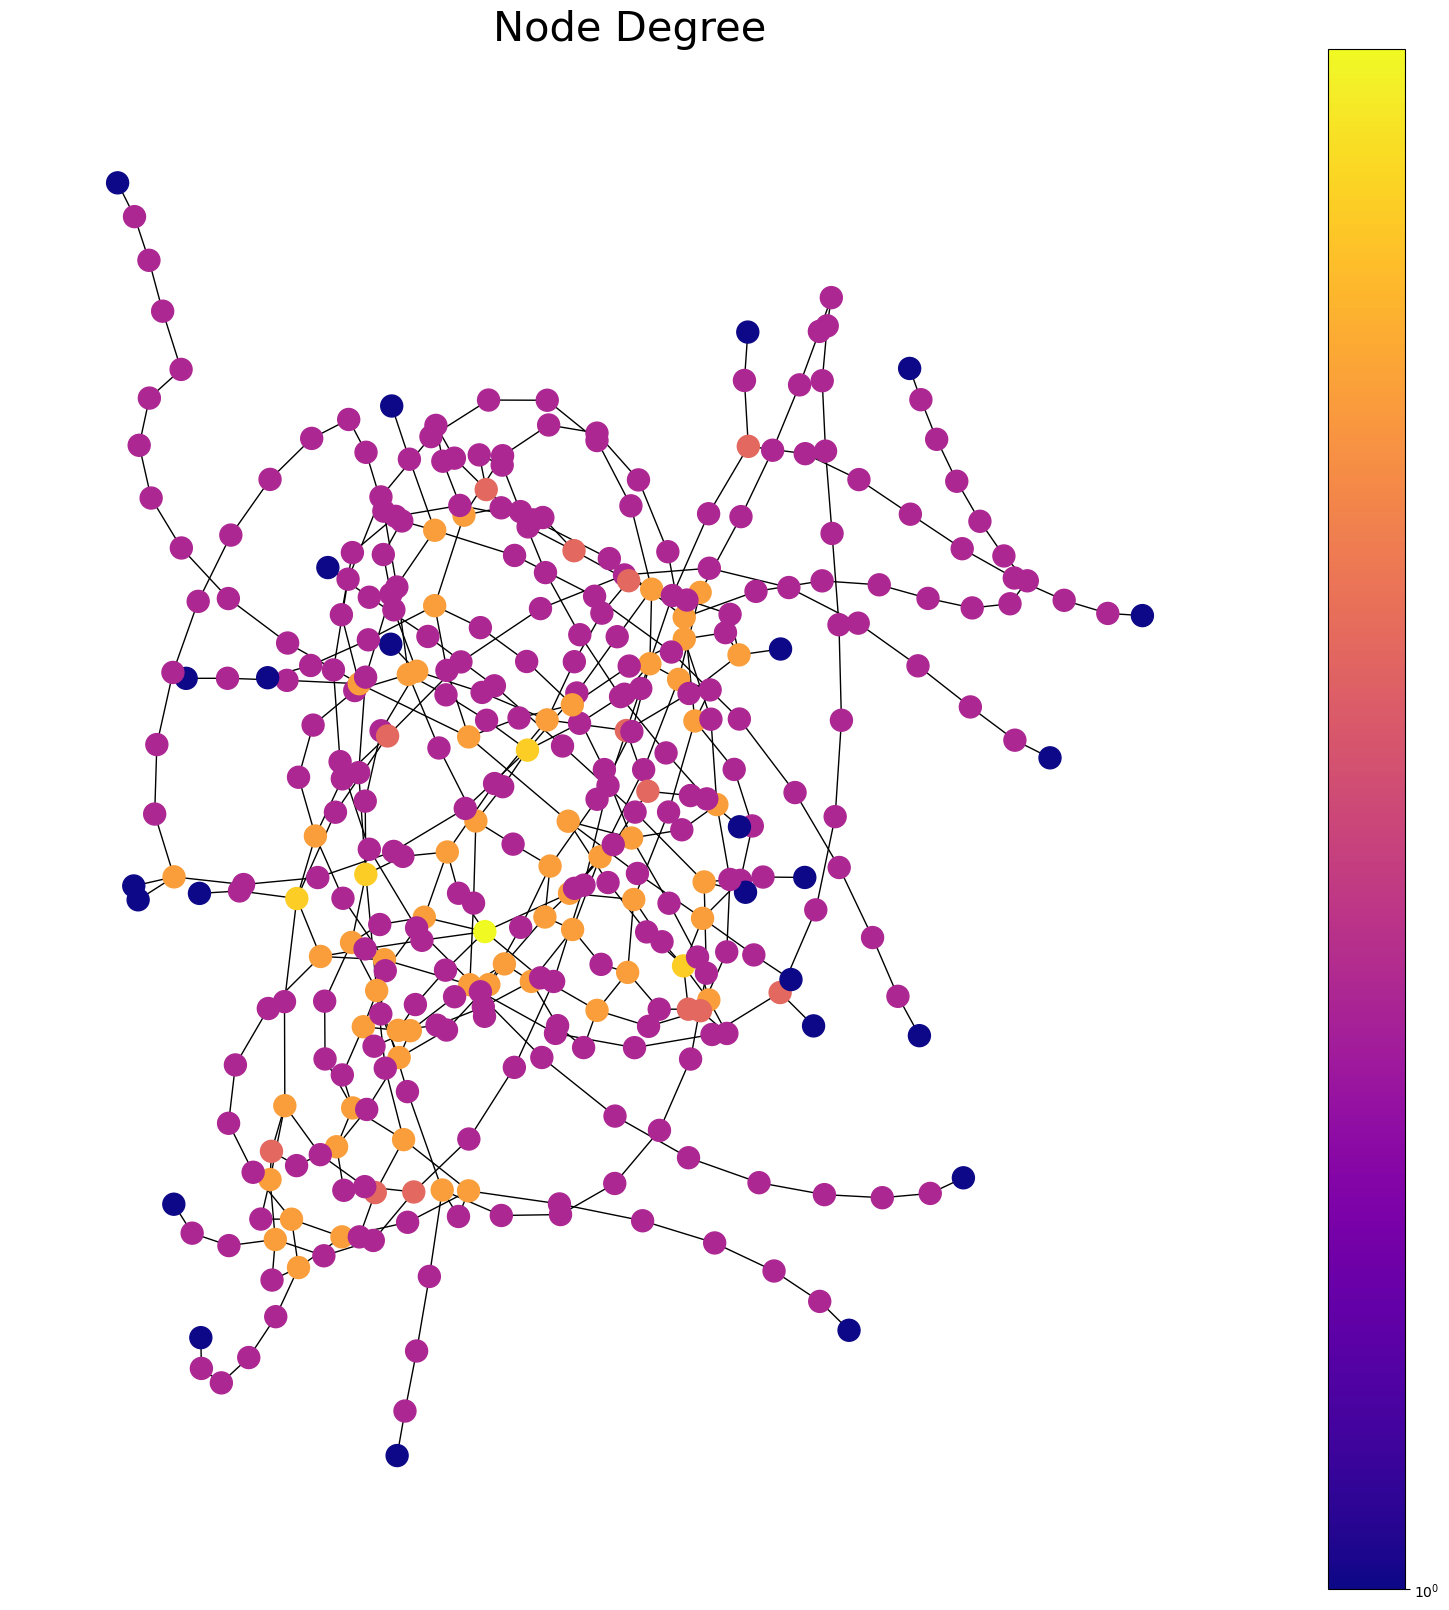

In [28]:
# node degree
print(dict_sort_by_name(dict(G.degree())))
draw(G, pos, dict(G.degree()), 'Node Degree')

In [30]:
# Engenvector Centrality ! Not Converged
# draw(G, pos, nx.eigenvector_centrality(G), 'Eigenvector Centrality')

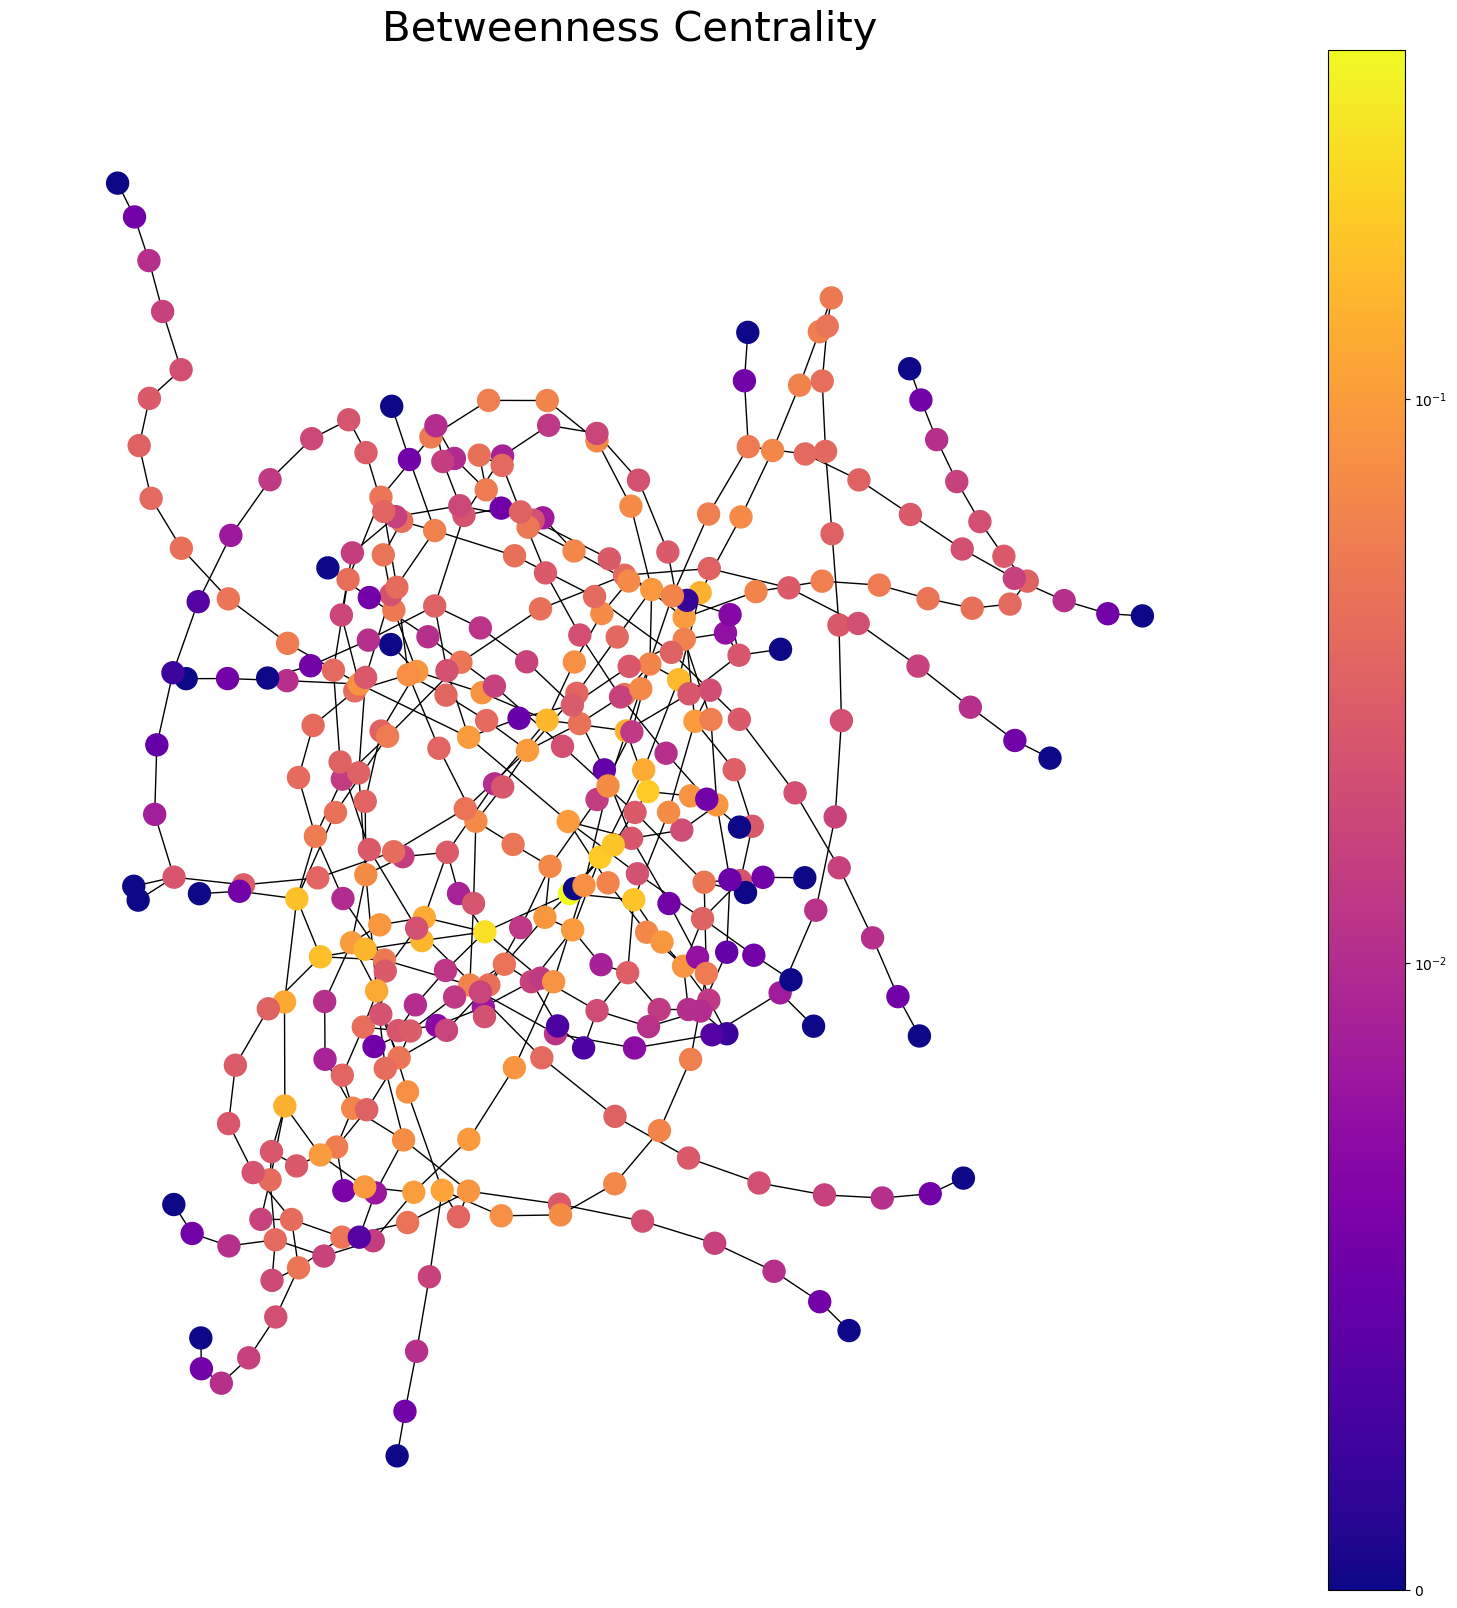

In [31]:
# Betweenness Centrality
draw(G, pos, nx.betweenness_centrality(G, weight='time'), 'Betweenness Centrality')

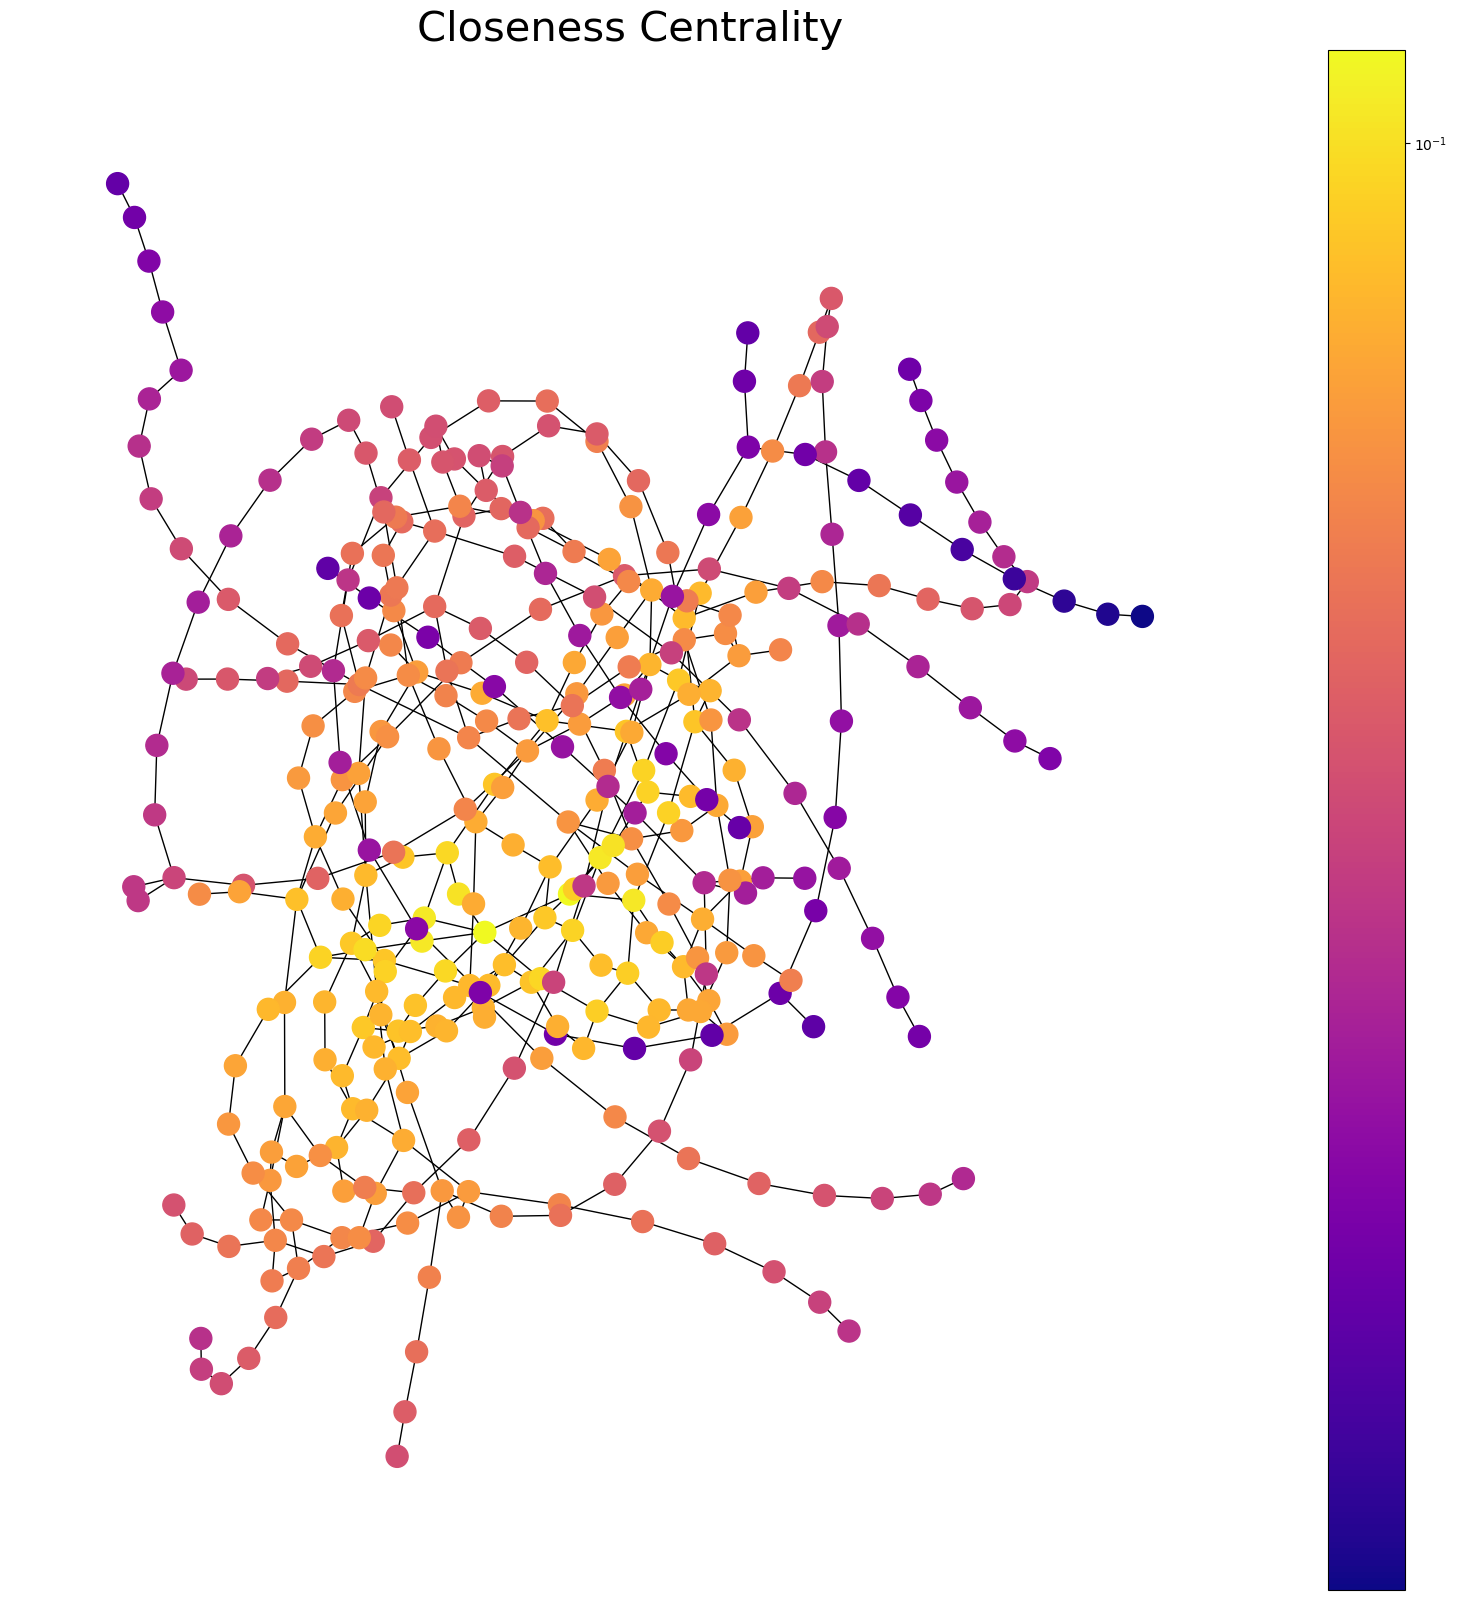

In [32]:
# clossness_centrality
draw(G, pos, nx.closeness_centrality(G), 'Closeness Centrality')

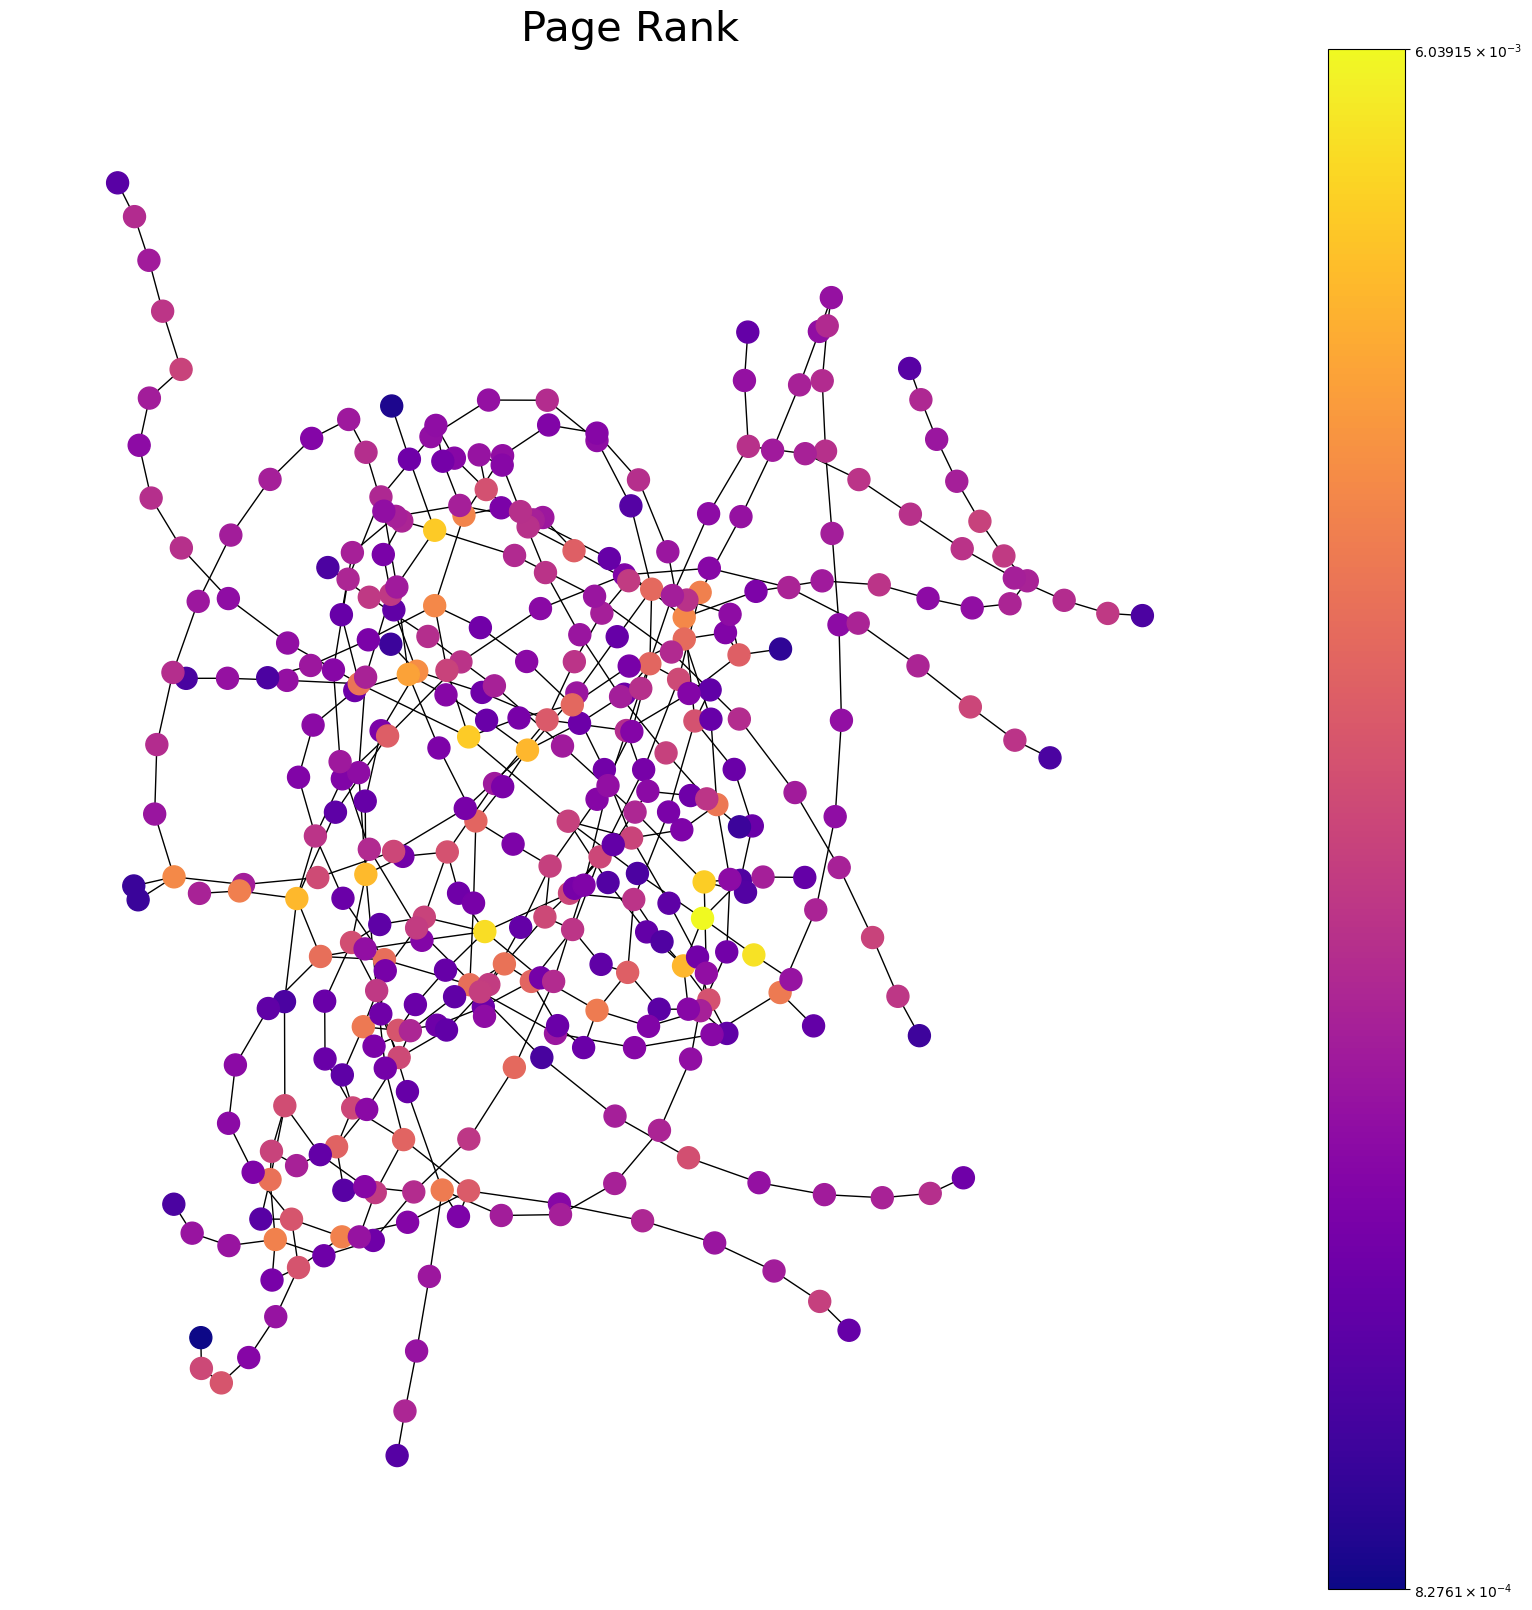

In [33]:
# PageRank
# nx.pagerank(G)
draw(G, pos, nx.pagerank(G, weight='time'), 'Page Rank')